#### MLP neural net regressor 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense,Conv2D, Dropout, Activation, MaxPooling2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import time 

#### Data load, preprocess

In [2]:
%%time
# preprocess: data import, shuffle, axes switch. detailed in notebk 'rgb_data_load_mod.ipynb'.

b = np.load('../Downloads/depth_training_data.npz')
data_rgb = b['rgb_images']                # RGB DATA 
data_depth = b['depth_maps']              # DEPTH DATA 
data_rgb = data_rgb/255
data_depth = data_depth - data_depth.min()
# switch axes for plotting
data_rgb = data_rgb.transpose(0,2,3,1)
data_depth = data_depth.transpose(0,2,3,1)
# shuffle images
random.seed(400)
random.shuffle(data_depth)     # inplace method
random.seed(400)
random.shuffle(data_rgb)

X = data_rgb.reshape(data_rgb.shape[0],27648)         # flatten
Y = data_depth.reshape(data_depth.shape[0],9216)

CPU times: user 2.04 s, sys: 517 ms, total: 2.56 s
Wall time: 2.6 s


#### Split Train-test

In [3]:
# small data selected as kernel kept dying  
data_rgb,data_depth,X,Y = data_rgb[:1000],data_depth[:1000],X[:1000],Y[:1000]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.20, random_state = 80)

# splitting actual color image w/ same random state for plotting with depth & predicted depth image
rgb_train, rgb_test = train_test_split(data_rgb, test_size= 0.20, random_state = 80)

#### Fit model with regularization- plot predicted depth results alongside actual images

The Mean square error using the MLP Regressor when alpha =0.0001 is  0.027
The Mean square error using the MLP Regressor when alpha =0.001 is  0.022
The Mean square error using the MLP Regressor when alpha =0.01 is  0.02
The Mean square error using the MLP Regressor when alpha =0.1 is  0.04
The Mean square error using the MLP Regressor when alpha =1 is  0.035
The Mean square error using the MLP Regressor when alpha =10 is  0.046
The Mean square error using the MLP Regressor when alpha =20 is  0.028
The Mean square error using the MLP Regressor when alpha =30 is  0.027


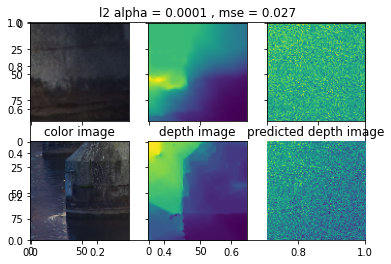

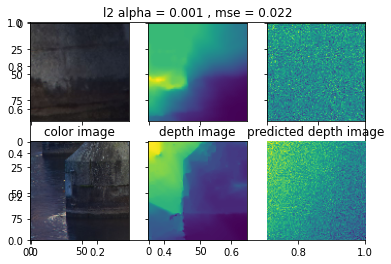

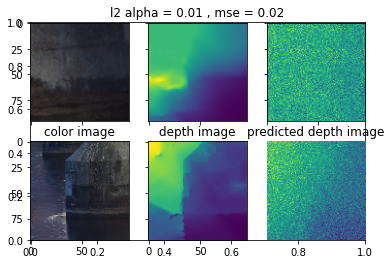

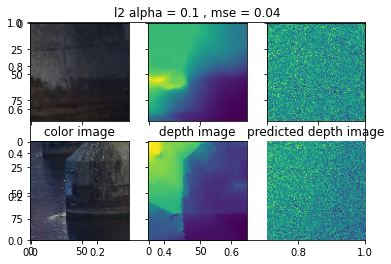

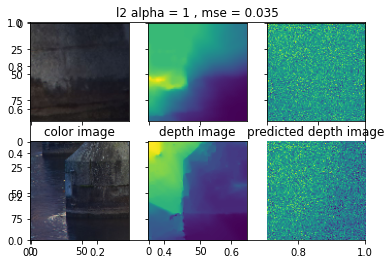

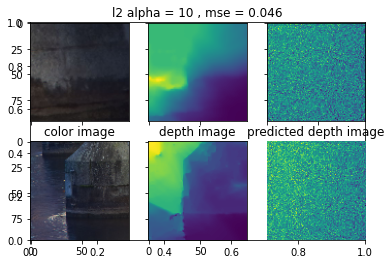

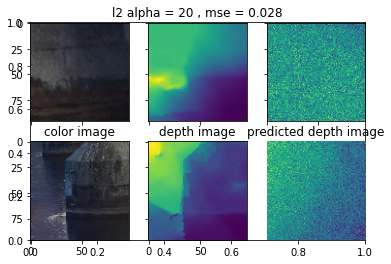

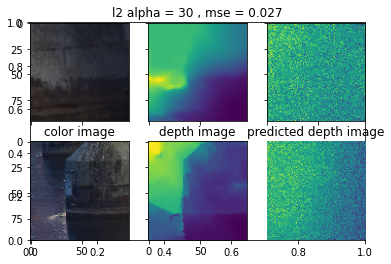

In [5]:
def MLN(x,y,c):
    mln_reg= MLPRegressor(hidden_layer_sizes=(128,64), alpha = c, early_stopping=True, validation_fraction=0.2)
    m = mln_reg.fit(x, y)
    y_pred = m.predict(x_test)
    mse_val = mean_squared_error(y_test,y_pred)
    print(f"The Mean square error using the MLP Regressor when alpha ={c} is {mse_val : 3.2}")
    f = plt.figure()
    plt.title(f"l2 alpha = {c} , mse = {mse_val :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[15])
    axarr[0,1].imshow(y_test[15].reshape(96,96,1))
    axarr[0,2].imshow(y_pred[15].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[150])
    axarr[1,1].imshow(y_test[150].reshape(96,96,1))
    axarr[1,2].imshow(y_pred[150].reshape(96,96,1))
    axarr[1,0].set_title('color image')       
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()
    return m, y_pred, mse_val

tic1=time.perf_counter()    
m1, y_pred1, mse_val1 = MLN(x_train,y_train,0.0001)
m2, y_pred2, mse_val2 = MLN(x_train,y_train,0.001)
m3, y_pred3, mse_val3 = MLN(x_train,y_train,0.01)
m4, y_pred4, mse_val4 = MLN(x_train,y_train,0.1)
m5, y_pred5, mse_val5 = MLN(x_train,y_train,1)
m6, y_pred6, mse_val6 = MLN(x_train,y_train,10)
m7, y_pred7, mse_val7 = MLN(x_train,y_train,20)
m8, y_pred8, mse_val8 = MLN(x_train,y_train,30)

toc1=time.perf_counter()

In [6]:
print("time for MLP using flattened i/p:",(toc1-tic1)/60,"minutes")

time for MLP using flattened i/p: 7.744612980633333 minutes


#### convoluting rgb image

In [7]:
%%time
# MLP using convoluted x 
#conv
tic3=time.perf_counter() 
input_shape = data_rgb.shape
x = data_rgb  # no padding, strides default
y = tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=input_shape[1:])(x)
x_f = tf.keras.layers.MaxPool2D()(y)
x_f.shape
y1 = tf.keras.layers.Conv2D(64, 3, activation='relu')(x_f)
y1.shape
x_ff = tf.keras.layers.MaxPool2D()(y1)
x_ff.shape
x_fff = tf.keras.layers.GlobalAveragePooling2D()(x_ff) 

toc3=time.perf_counter() 
print("time for 2 layered convolution:",(toc3-tic3)/60,"minutes")
xconv = x_fff.numpy()

2022-01-04 22:38:59.728820: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


time for 2 layered convolution: 0.6947227905333335 minutes
CPU times: user 20.3 s, sys: 36.3 s, total: 56.6 s
Wall time: 41.7 s


#### Splitting conv X into train test 

In [8]:
xc_train, xc_test, y_train, y_test = train_test_split(xconv, Y, test_size= 0.20, random_state = 80)
xc_train.shape

(800, 64)

#### Fitting model on convoluted X variable- rgb image

The Mean square error using the MLP Regressor when alpha =0.0001 is  0.0039


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =0.001 is  0.0033
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0044


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =0.05 is  0.0034
The Mean square error using the MLP Regressor when alpha =0.1 is  0.0036


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =0.5 is  0.0041


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =1 is  0.0036


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =10 is  0.0044


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Mean square error using the MLP Regressor when alpha =20 is  0.0047
The Mean square error using the MLP Regressor when alpha =30 is  0.0054
CPU times: user 4min 20s, sys: 17.8 s, total: 4min 38s
Wall time: 2min 20s


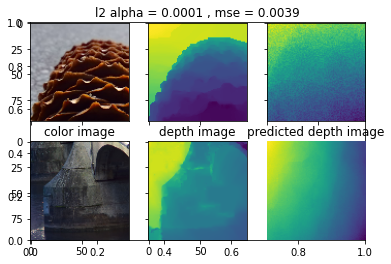

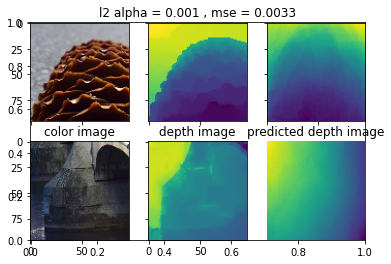

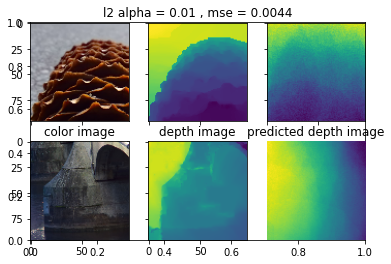

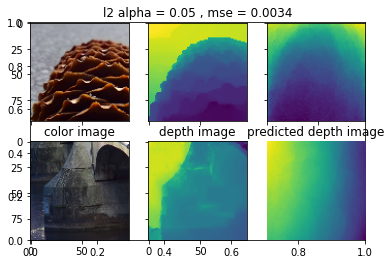

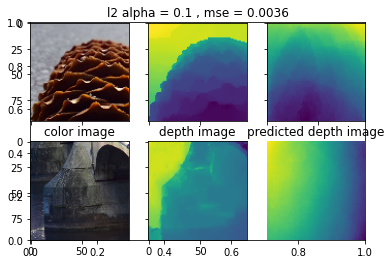

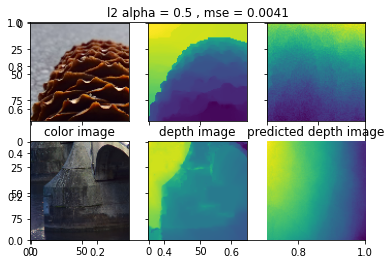

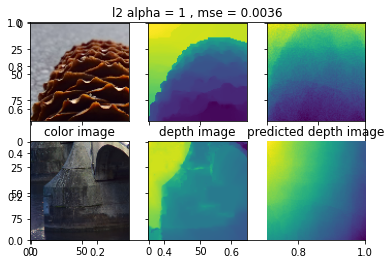

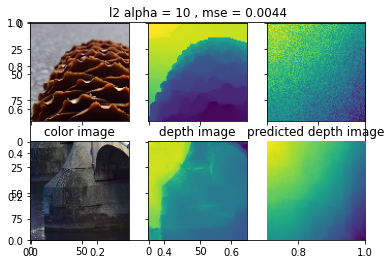

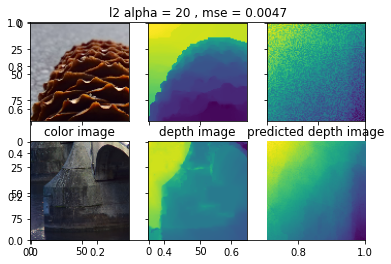

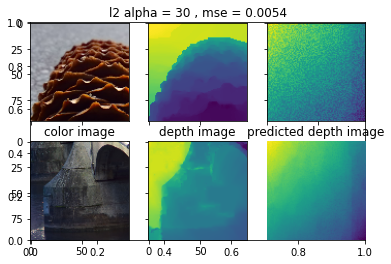

In [9]:
%%time
c = [0.0001,0.001,0.01,0.05,0.1,0.5,1,10,20,30]
for i in c:
    mln_reg= MLPRegressor(hidden_layer_sizes=(128,64), alpha = i, early_stopping=True, validation_fraction=0.2)
    m = mln_reg.fit(xc_train, y_train)
    y_pred = m.predict(xc_test)
    mse_val = mean_squared_error(y_test,y_pred)
    print(f"The Mean square error using the MLP Regressor when alpha ={i} is {mse_val : 3.2}")
    f = plt.figure()
    plt.title(f"l2 alpha = {i} , mse = {mse_val :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[20])
    axarr[0,1].imshow(y_test[20].reshape(96,96,1))
    axarr[0,2].imshow(y_pred[20].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[151])
    axarr[1,1].imshow(y_test[151].reshape(96,96,1))
    axarr[1,2].imshow(y_pred[151].reshape(96,96,1))
    axarr[1,0].set_title('color image')       
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### time taken for training & testing on simple flattened input vs convoluted input

In [15]:
print(f"Flattened data:,{toc1-tic1 :3.5} seconds")
print("Convoluted data: 140 seconds") # from wall time in above cell

Flattened data:,464.68 seconds
Convoluted data: 140 seconds


#### Plotting more images with model which looks best 
#### Alpha = 1 and 2 dense layers of 128, 64

The Mean square error using the MLP Regressor when alpha =0.01 is  0.022
The Mean square error using the MLP Regressor when alpha =0.01 is  0.02
The Mean square error using the MLP Regressor when alpha =0.01 is  0.024
The Mean square error using the MLP Regressor when alpha =0.01 is  0.021
The Mean square error using the MLP Regressor when alpha =0.01 is  0.021
The Mean square error using the MLP Regressor when alpha =0.01 is  0.019
The Mean square error using the MLP Regressor when alpha =0.01 is  0.024
The Mean square error using the MLP Regressor when alpha =0.01 is  0.021
The Mean square error using the MLP Regressor when alpha =0.01 is  0.022
The Mean square error using the MLP Regressor when alpha =0.01 is  0.023
The Mean square error using the MLP Regressor when alpha =0.01 is  0.03
The Mean square error using the MLP Regressor when alpha =0.01 is  0.02
The Mean square error using the MLP Regressor when alpha =0.01 is  0.018


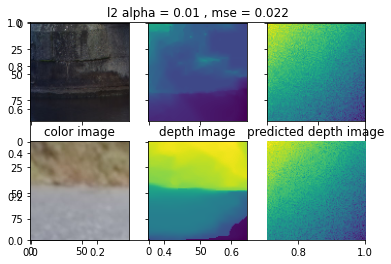

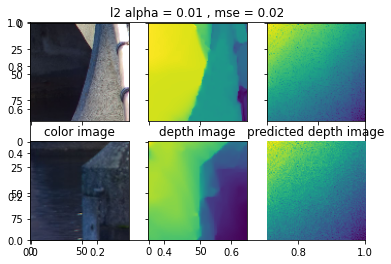

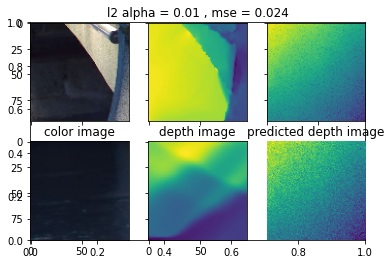

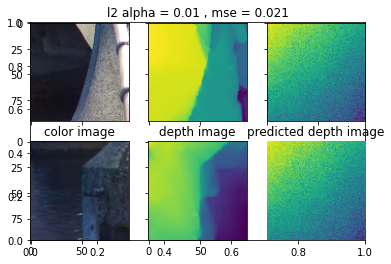

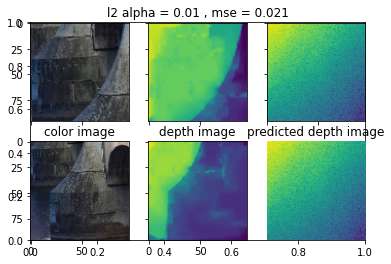

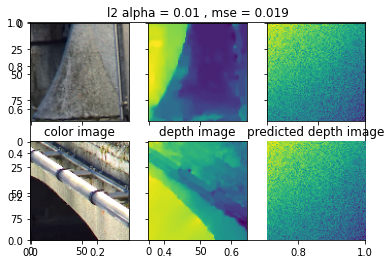

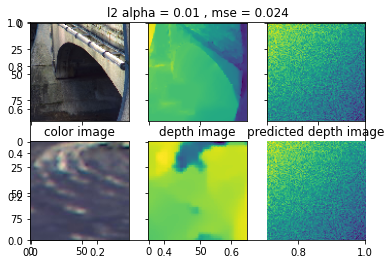

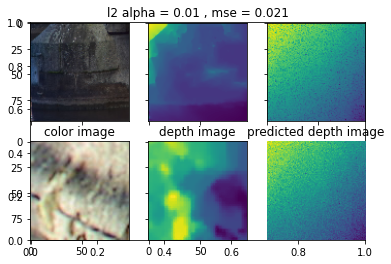

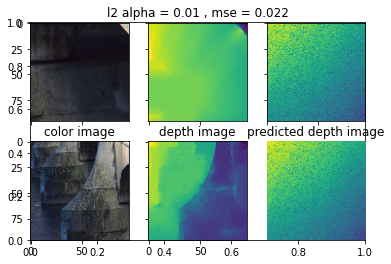

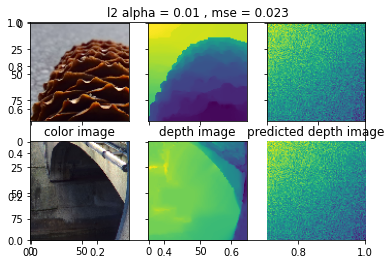

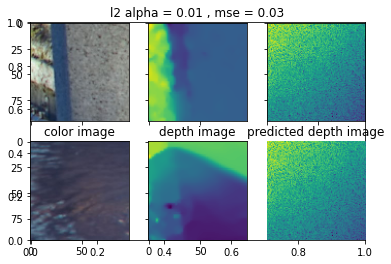

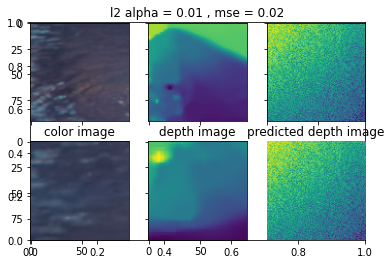

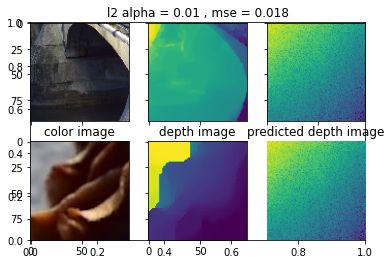

In [16]:
c = [121,45,189,45,64,79,139,182,10,20,30,31,54] # image numbers 
for i in c:
    mln_reg= MLPRegressor(hidden_layer_sizes=(128,64), alpha = 1)
    m = mln_reg.fit(xc_train, y_train)
    y_pred = m.predict(xc_test)
    mse_val = mean_squared_error(y_test,y_pred)
    print(f"The Mean square error using the MLP Regressor when alpha =0.01 is {mse_val : 3.2}")
    f = plt.figure()
    plt.title(f"l2 alpha = 0.01 , mse = {mse_val :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(y_pred[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(y_pred[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')       
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### Alpha = 1 and 2 dense layers of 64, 32

The Mean square error using the MLP Regressor when alpha =0.01 is  0.042
The Mean square error using the MLP Regressor when alpha =0.01 is  0.047
The Mean square error using the MLP Regressor when alpha =0.01 is  0.028
The Mean square error using the MLP Regressor when alpha =0.01 is  0.066
The Mean square error using the MLP Regressor when alpha =0.01 is  0.12
The Mean square error using the MLP Regressor when alpha =0.01 is  0.028
The Mean square error using the MLP Regressor when alpha =0.01 is  0.051
The Mean square error using the MLP Regressor when alpha =0.01 is  0.03
The Mean square error using the MLP Regressor when alpha =0.01 is  0.033
The Mean square error using the MLP Regressor when alpha =0.01 is  0.025
The Mean square error using the MLP Regressor when alpha =0.01 is  0.024
The Mean square error using the MLP Regressor when alpha =0.01 is  0.028
The Mean square error using the MLP Regressor when alpha =0.01 is  0.026


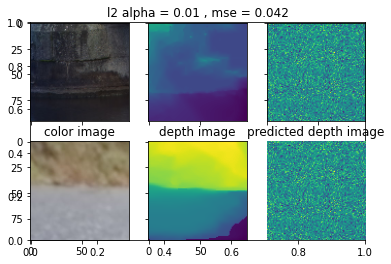

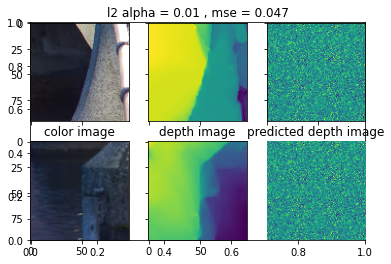

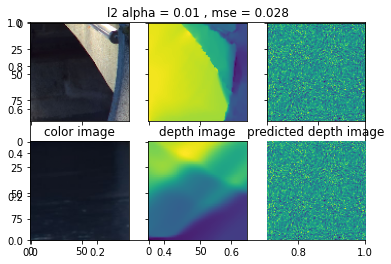

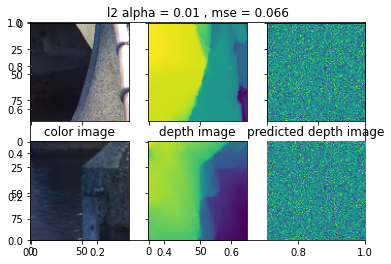

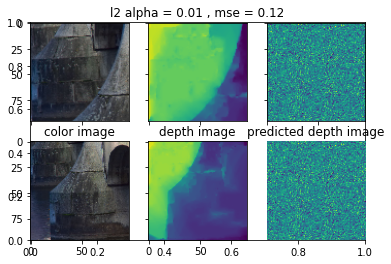

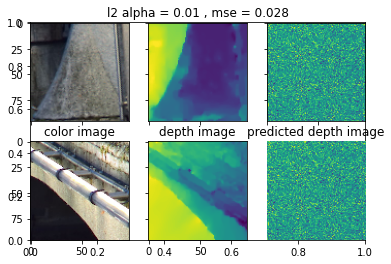

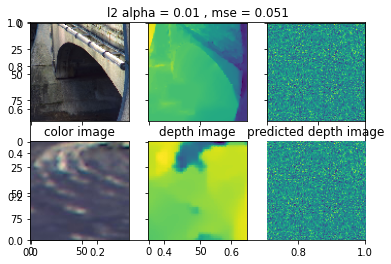

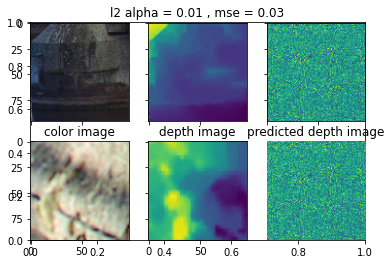

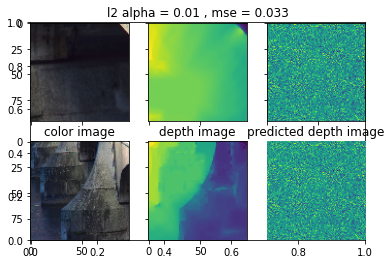

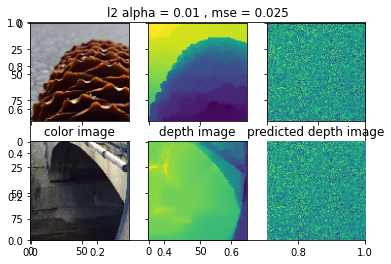

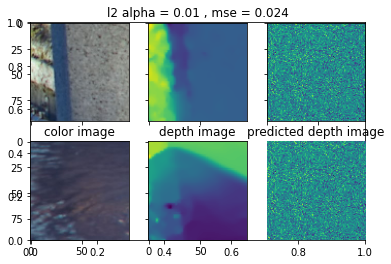

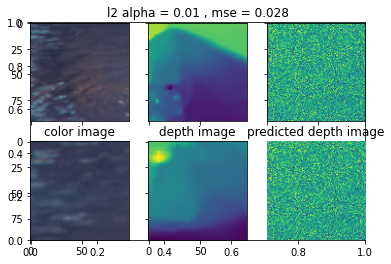

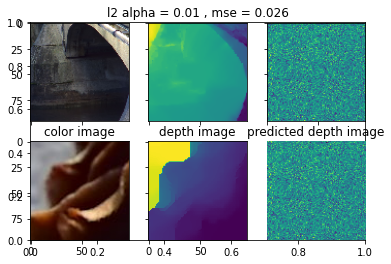

In [17]:
c = [121,45,189,45,64,79,139,182,10,20,30,31,54] # image numbers 
for i in c:
    mln_reg= MLPRegressor(hidden_layer_sizes=(64,32), alpha = 1)
    m = mln_reg.fit(xc_train, y_train)
    y_pred = m.predict(xc_test)
    mse_val = mean_squared_error(y_test,y_pred)
    print(f"The Mean square error using the MLP Regressor when alpha =0.01 is {mse_val : 3.2}")
    f = plt.figure()
    plt.title(f"l2 alpha = 0.01 , mse = {mse_val :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(y_pred[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(y_pred[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')       
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### adding another layer

The Mean square error using the MLP Regressor when alpha =0.01 is  0.0057
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0057
The Mean square error using the MLP Regressor when alpha =0.01 is  0.006
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0063
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0058
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0058
The Mean square error using the MLP Regressor when alpha =0.01 is  0.006
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0055
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0064
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0059
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0059
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0063
The Mean square error using the MLP Regressor when alpha =0.01 is  0.0058


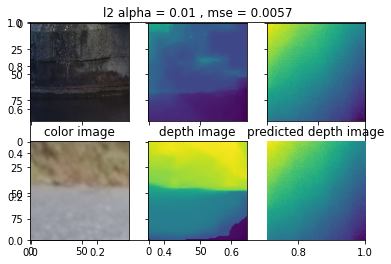

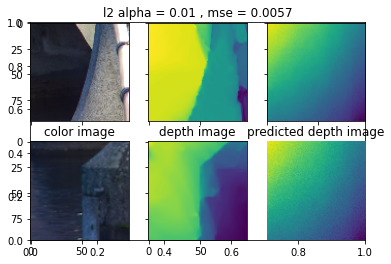

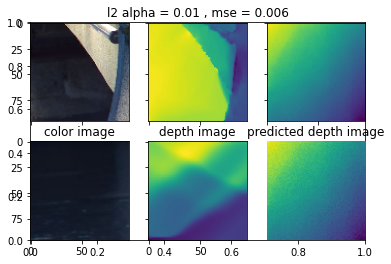

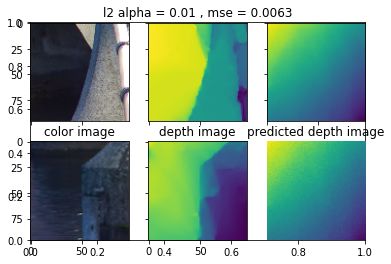

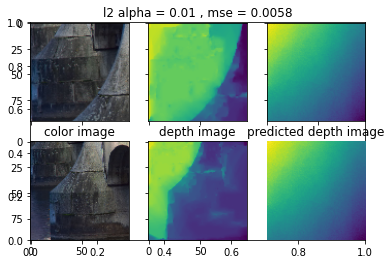

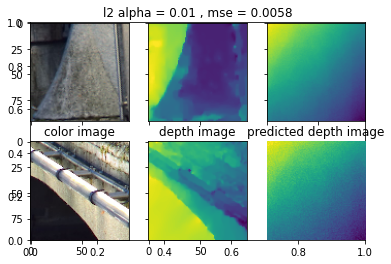

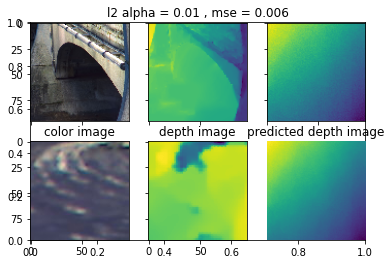

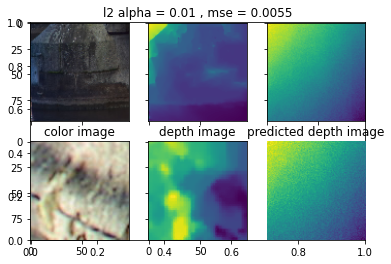

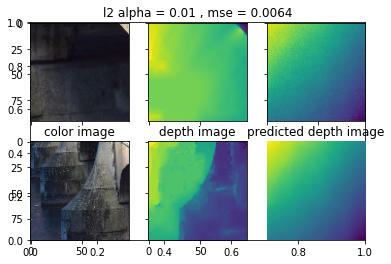

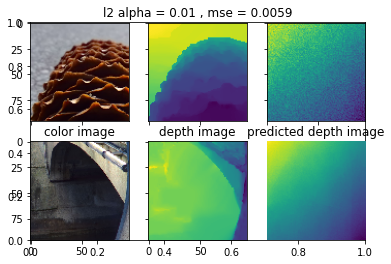

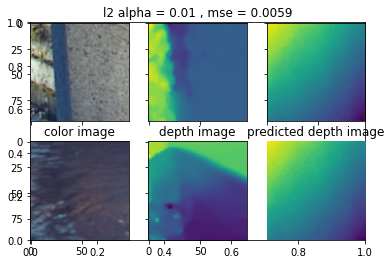

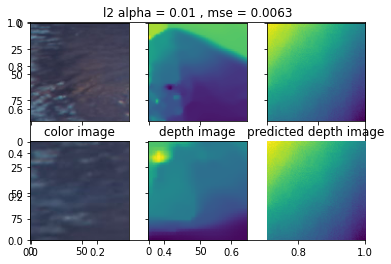

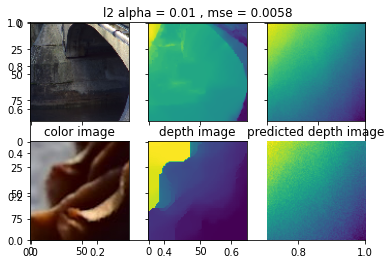

In [12]:
c = [121,45,189,45,64,79,139,182,10,20,30,31,54] # image numbers 
for i in c:
    mln_reg= MLPRegressor(hidden_layer_sizes=(128,128,64), alpha =0.001)
    m = mln_reg.fit(xc_train, y_train)
    y_pred = m.predict(xc_test)
    mse_val = mean_squared_error(y_test,y_pred)
    print(f"The Mean square error using the MLP Regressor when alpha =0.01 is {mse_val : 3.2}")
    f = plt.figure()
    plt.title(f"l2 alpha = 0.01 , mse = {mse_val :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(y_pred[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(y_pred[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')       
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

### MLP models do not make a good fit, instead make the same predictions for each new data.  

#### Using convoluted X we bring down prediction mse by 1 whole decimal point, and reduce computation time by over 300%